# Import Necesssary Packages

In [269]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [215]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import bisect
from scipy.sparse import hstack

# Read the data

In [179]:
kdd_data = pd.read_csv('/content/orange_small_train.txt', delimiter="\t")

In [180]:
kdd_data['appetency_labels'] = pd.read_table("/content/orange_small_train_appetency.labels", header = None, names = ['appetency'])
kdd_data['churn_labels'] = pd.read_table("/content/orange_small_train_churn.labels", header = None, names = ['churn'])
kdd_data['upselling_labels'] = pd.read_table("/content/orange_small_train_upselling.labels", header= None, names = ['upselling'])

In [182]:
kdd_data['appetency_labels'] = kdd_data['appetency_labels'].replace(-1, 0)
kdd_data['churn_labels'] = kdd_data['churn_labels'].replace(-1, 0)
kdd_data['upselling_labels'] = kdd_data['upselling_labels'].replace(-1, 0)

In [ ]:
print("There are", kdd_data.shape[0], "observations and", kdd_data.shape[1], "variables")

There are 50000 observations and 233 variables


# Handling missing values

In [183]:
kdd_data.isna().sum()

Var1                49298
Var2                48759
Var3                48760
Var4                48421
Var5                48513
                    ...  
Var229              28432
Var230              50000
appetency_labels        0
churn_labels            0
upselling_labels        0
Length: 233, dtype: int64

## Drop column if over 40% of the columns are null values

In [265]:
columns= [cols for cols in kdd_data.columns if kdd_data[cols].isnull().sum()/kdd_data.shape[0] > 0.40] #Selecting columns that have over 40% of null values

In [185]:
kdd_data.drop(columns, axis = 1, inplace = True) #Dropping columns

In [186]:
len(kdd_data.columns)

70

In [187]:
kdd_data.dtypes #Types of the columns

Var6                float64
Var7                float64
Var13               float64
Var21               float64
Var22               float64
                     ...   
Var227               object
Var228               object
appetency_labels      int64
churn_labels          int64
upselling_labels      int64
Length: 70, dtype: object

In [188]:
kdd_data.isna().sum() # Number of null values in each column

Var6                5529
Var7                5539
Var13               5539
Var21               5529
Var22               5009
                    ... 
Var227                 0
Var228                 0
appetency_labels       0
churn_labels           0
upselling_labels       0
Length: 70, dtype: int64

In [189]:
missing_data = pd.DataFrame({'Column': kdd_data.columns, 'NA_count': kdd_data.isna().sum()})

In [190]:
fig = px.bar(x= missing_data.Column, y=missing_data.NA_count, labels={'x':'Column', 'y':'Missing Value Count'}, title='Missing Value counts')
fig.show()

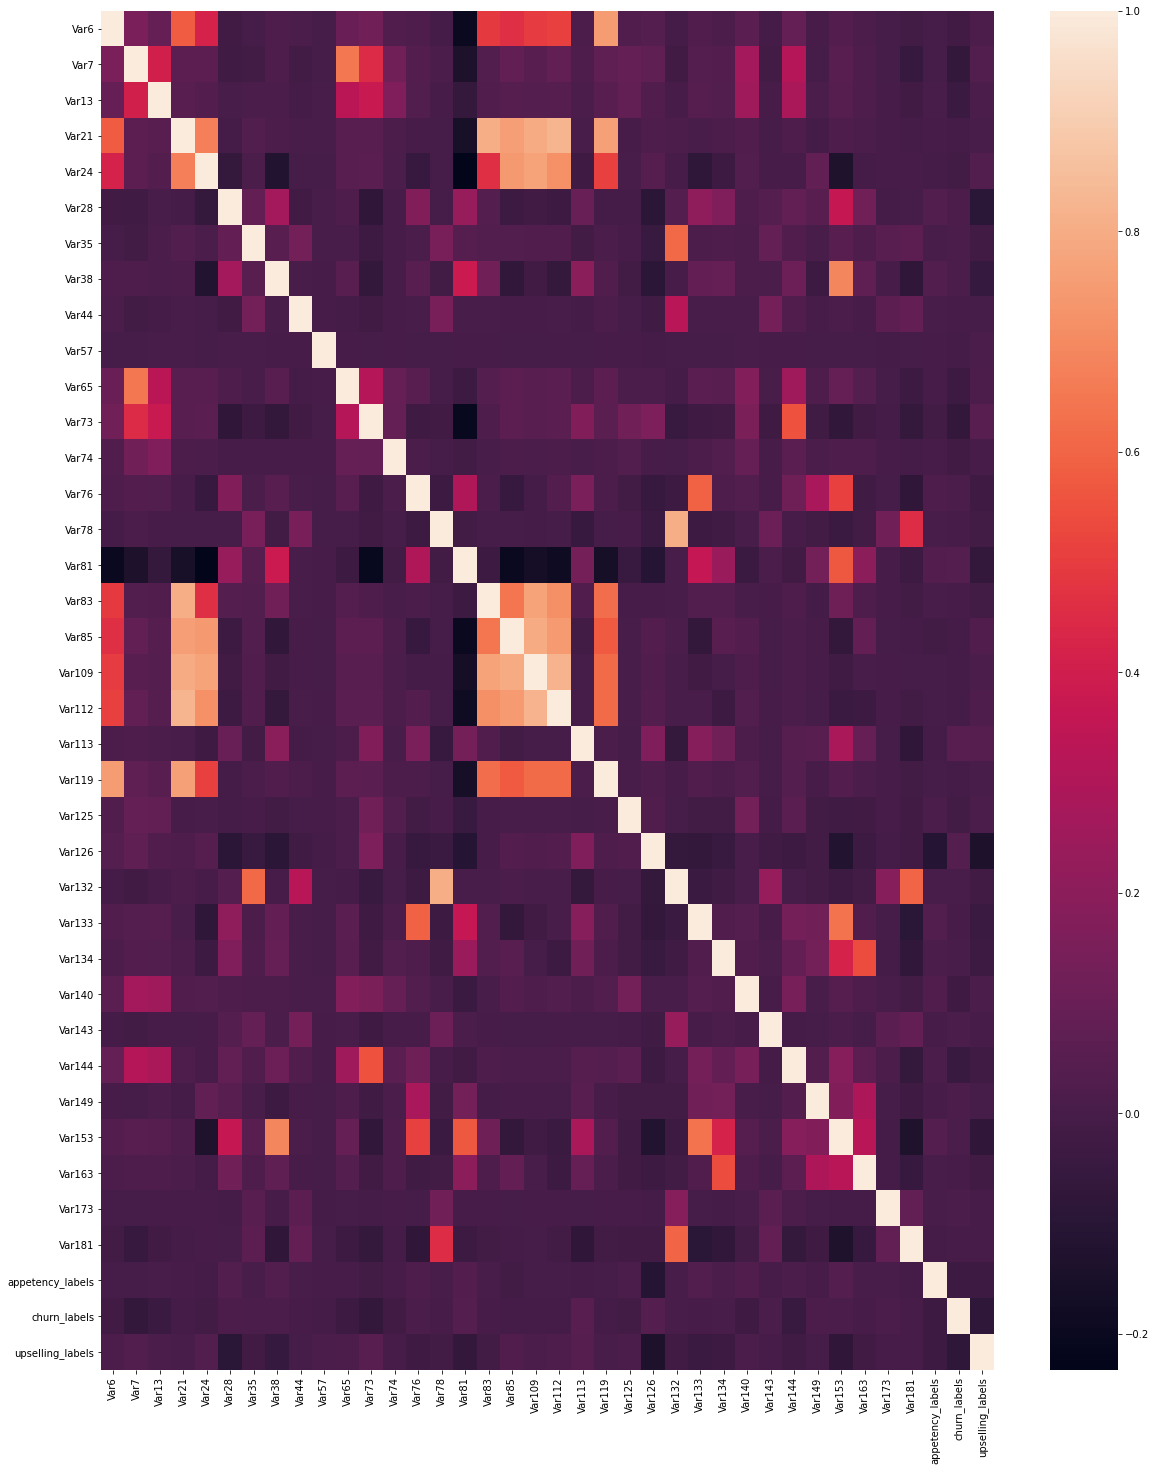

In [267]:
plt.figure(figsize=(20,25))
sns.heatmap(kdd_data.corr())


## Removing Highly correlated columns

In [192]:
corr_matrix = kdd_data.corr().abs()

In [193]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [194]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [195]:
to_drop

['Var22', 'Var25', 'Var123', 'Var160']

In [196]:
kdd_data.drop(to_drop, axis=1, inplace=True)

## Handling Categorical Null Variables

In [197]:
cols=[col for col in kdd_data.columns if kdd_data[col].dtype=='O']

In [198]:
kdd_data[cols].isna().sum()

Var192     369
Var193       0
Var195       0
Var196       0
Var197     143
Var198       0
Var199       4
Var202       1
Var203     143
Var204       0
Var205    1934
Var206    5529
Var207       0
Var208     143
Var210       0
Var211       0
Var212       0
Var216       0
Var217     703
Var218     703
Var219    5211
Var220       0
Var221       0
Var222       0
Var223    5211
Var226       0
Var227       0
Var228       0
dtype: int64

In [199]:
cols_value_counts = [(i, kdd_data[i].nunique()) for i in cols] #Checking the number of unique values in each categorical variable

In [200]:
cols_value_counts

[('Var192', 361),
 ('Var193', 51),
 ('Var195', 23),
 ('Var196', 4),
 ('Var197', 225),
 ('Var198', 4291),
 ('Var199', 5073),
 ('Var202', 5713),
 ('Var203', 5),
 ('Var204', 100),
 ('Var205', 3),
 ('Var206', 21),
 ('Var207', 14),
 ('Var208', 2),
 ('Var210', 6),
 ('Var211', 2),
 ('Var212', 81),
 ('Var216', 2016),
 ('Var217', 13990),
 ('Var218', 2),
 ('Var219', 22),
 ('Var220', 4291),
 ('Var221', 7),
 ('Var222', 4291),
 ('Var223', 4),
 ('Var226', 23),
 ('Var227', 7),
 ('Var228', 30)]

In [201]:
cols_new = [i for i in cols if kdd_data[i].nunique() < 100] #Selecting only those categorical variables with less than 

In [202]:
kdd_data[cols_new].isna().sum() #Null values in these columns

Var193       0
Var195       0
Var196       0
Var203     143
Var205    1934
Var206    5529
Var207       0
Var208     143
Var210       0
Var211       0
Var212       0
Var218     703
Var219    5211
Var221       0
Var223    5211
Var226       0
Var227       0
Var228       0
dtype: int64

In [203]:
kdd_data['Var203'].value_counts() #Distribution of each column

9_Y1    45233
HLqf     3168
F3hy     1451
dgxZ        4
pybr        1
Name: Var203, dtype: int64

In [204]:
kdd_data['Var208'].value_counts() #Distribution of each column

kIsH    46022
sBgB     3835
Name: Var208, dtype: int64

In [205]:
kdd_data['Var219'].value_counts() #Distribution of each column

FzaX          40304
AU8pNoi        1109
qxDb           1088
OFWH            834
AU8_WTd         552
wwPEXoilkr      448
Lmli            264
tdJW_Pm          78
FqMWi1g          33
ylgWTXl          21
AU8ltHK          10
AU8OvAe           9
FQHxeR8           9
JdAM              9
AU8KzzF           5
49W0rUY           4
lkwAXjv           3
AT1N              2
49W9HeL           2
6krWwfF           2
HEoH              2
kgEg              1
Name: Var219, dtype: int64

In [206]:
kdd_data['Var223'].value_counts() #Distribution of each column

LM8l689qOp    36608
jySVZNlOJy     5995
M_8D           2022
bCPvVye         164
Name: Var223, dtype: int64

In [207]:
kdd_data['Var223'] #Distribution of each column

0        jySVZNlOJy
1        LM8l689qOp
2        jySVZNlOJy
3        LM8l689qOp
4        LM8l689qOp
            ...    
49995    LM8l689qOp
49996    LM8l689qOp
49997    LM8l689qOp
49998    LM8l689qOp
49999    LM8l689qOp
Name: Var223, Length: 50000, dtype: object

In [208]:
#Using max frequency handling for the following columns 
kdd_data[['Var208', 'Var219', 'Var203', 'Var223']] = kdd_data[['Var208', 'Var219', 'Var203', 'Var223']].apply(lambda x:x.fillna(x.value_counts().index[0]))  

In [209]:
#Using forward fill for these columns
kdd_data[['Var205', 'Var206', 'Var218']]=kdd_data[['Var205', 'Var206', 'Var218']].ffill(axis=0)

In [210]:
kdd_data[cols_new].isna().sum()

Var193    0
Var195    0
Var196    0
Var203    0
Var205    0
Var206    0
Var207    0
Var208    0
Var210    0
Var211    0
Var212    0
Var218    0
Var219    0
Var221    0
Var223    0
Var226    0
Var227    0
Var228    0
dtype: int64

# Handling Numerical NA values

In [211]:
num_cols=[col for col in kdd_data.columns if kdd_data[col].dtype=='float64']

In [235]:
cat_cols=[col for col in kdd_data.columns if kdd_data[col].dtype=='O']

In [212]:
kdd_data.drop(['Var192', 'Var197', 'Var199', 'Var202', 'Var217'], axis = 1, inplace = True)

In [213]:
kdd_data[num_cols] = kdd_data[num_cols].apply(lambda x:x.fillna(x.mean())) #FIlling values with NA values

# Handling categorical variables for processing

In [241]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y_churn = kdd_data['churn_labels']
x_train, x_val, y_train_churn, y_val_churn = train_test_split(x, y_churn, test_size=0.2, random_state=21)

In [280]:
def process_data(x_train, x_val):
  le=LabelEncoder()
  x_train['Var193']=le.fit_transform(x_train['Var193'])
  x_val['Var193'] = x_val['Var193'].map(lambda s: 'other' if s not in le.classes_ else s)
  le_classes = le.classes_.tolist()
  bisect.insort_left(le_classes, 'other')
  le.classes_ = le_classes
      
  x_val['Var193']=le.transform(x_val['Var193'])
      
  ohe=OneHotEncoder(handle_unknown='ignore')
  X_tr = ohe.fit_transform(x_train['Var193'].values.reshape(-1,1))
  X_te = ohe.transform(x_val['Var193'].values.reshape(-1,1))
  flag=0    
  for i in cat_cols:
    
    if (flag!=0):

          le = LabelEncoder()
          x_train[i]=le.fit_transform(x_train[i])
          x_val[i] = x_val[i].map(lambda s: 'other' if s not in le.classes_ else s)
          le_classes = le.classes_.tolist()
          bisect.insort_left(le_classes, 'other')
          le.classes_ = le_classes
          x_val[i]=le.transform(x_val[i])
          ohe=OneHotEncoder(handle_unknown='ignore')
          print(i)
          X_tri = ohe.fit_transform(x_train[i].values.reshape(-1,1))
          X_tei = ohe.transform(x_val[i].values.reshape(-1,1))
          X_tr=hstack((X_tr,X_tri))
          X_te=hstack((X_te,X_tei))

    flag=1

# Base Models for churn using Logistic regression

In [243]:
# your code here 
s1 = x_train[y_train_churn==0]
s2 = x_train[y_train_churn==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [244]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))

In [245]:
t_stats =  abs(t_stats).sort_values(ascending = False)

In [246]:
top15 = t_stats.index[:15]

In [247]:
print("The top 15 best predictors are", list(top15), sep = "\t")

The top 15 best predictors are	['Var73', 'Var7', 'Var144', 'Var113', 'Var207', 'Var126', 'Var13', 'Var74', 'Var193', 'Var140', 'Var65', 'Var218', 'Var205', 'Var81', 'Var211']


In [248]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [250]:
lreg_churn = LogisticRegression(random_state = 21)
lreg_churn.fit(x_train_new,y_train_churn)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [251]:
y_train_pred_churn = lreg_churn.predict(x_train_new)
y_val_pred_churn = lreg_churn.predict(x_val_new)

In [262]:
lreg_churn_probs = lreg_churn.predict_proba(x_val_new)
lreg_churn_probs = lreg_churn_probs[:, 1]

In [263]:
lr_auc_churn = roc_auc_score(y_val_churn, lreg_churn_probs)

In [264]:
print('Logistic: ROC AUC=%.3f' % (lr_auc_churn))

Logistic: ROC AUC=0.592


In [252]:
train_accuracy = accuracy_score(y_train_churn, y_train_pred_churn)
validation_accuracy = accuracy_score(y_val_churn, y_val_pred_churn)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.925
Validation Accuracy 0.929


In [253]:
conf_matrix = confusion_matrix(y_val_churn, y_val_pred_churn)

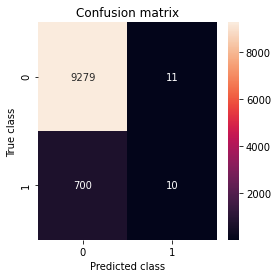

In [254]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [255]:
tn, fp, fn, tp = confusion_matrix(y_val_churn, y_val_pred_churn).ravel()

In [256]:
recall_churn = tp/(tp + fn)

In [257]:
FNR_value = 1 - recall_churn

In [258]:
FNR_value

0.9859154929577465

In [259]:
recall_churn

0.014084507042253521

In [260]:
roc_auc_score(y_train_churn, y_train_pred_churn)

0.501195370675933

In [270]:
f1_churn = f1_score(y_train_churn, y_train_pred_churn)
print("f1 score is ", np.round(f1_churn,3))

f1 score is  0.007


# Base Model for Upselling

In [272]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y_ups = kdd_data['upselling_labels']
x_train, x_val, y_train_ups, y_val_ups = train_test_split(x, y_ups, test_size=0.2, random_state=21)

In [ ]:
process_data(x_train, x_val)

In [282]:
# your code here 
s1 = x_train[y_train_ups==0]
s2 = x_train[y_train_ups==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [283]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))
t_stats =  abs(t_stats).sort_values(ascending = False)

In [284]:
best_pred = t_stats.index[0]
top15 = t_stats.index[:15]

In [285]:
print("The top 10 best predictors are", list(top10), sep = "\t")

The top 10 best predictors are	['Var73', 'Var212_NhsEn4L', 'Var7', 'Var193_RO12', 'Var228_F2FyR07IdsN7I', 'Var144', 'Var113', 'Var205_sJzTlal', 'Var126', 'Var13']


In [287]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [288]:
lreg_ups = LogisticRegression(random_state = 21)
lreg_ups.fit(x_train_new,y_train_ups)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [289]:
y_train_pred_ups = lreg_ups.predict(x_train_new)
y_val_pred_ups = lreg_ups.predict(x_val_new)

In [290]:
train_accuracy = accuracy_score(y_train_ups, y_train_pred_ups)
validation_accuracy = accuracy_score(y_val_ups, y_val_pred_ups)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.926
Validation Accuracy 0.927


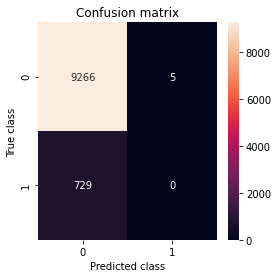

In [291]:
conf_matrix = confusion_matrix(y_val_ups, y_val_pred_ups)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [292]:
# generate a no skill prediction (majority class)
ns_ups_probs = [0] * len(x_val_new)

# predict probabilities
lreg_ups_probs = lreg_ups.predict_proba(x_val_new)
# keep probabilities for the positive outcome only
lreg_ups_probs = lreg_ups_probs[:, 1]
# calculate scores
ns_auc_ups = roc_auc_score(y_val_ups, ns_ups_probs)
lr_auc_ups = roc_auc_score(y_val_ups, lreg_ups_probs)

In [293]:
print('No Skill: ROC AUC=%.3f' % (ns_auc_ups))
print('Logistic: ROC AUC=%.3f' % (lr_auc_ups))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.668


In [294]:
f1_ups = f1_score(y_train_ups, y_train_pred_ups)
print("f1 score is ", np.round(f1_ups,3))

f1 score is  0.0


# Base Model appentency

In [295]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y_app = kdd_data['upselling_labels']
x_train, x_val, y_train_app, y_val_app = train_test_split(x, y_app, test_size=0.2, random_state=21)

In [296]:
# your code here 
s1 = x_train[y_train_app==0]
s2 = x_train[y_train_app==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [297]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))
t_stats =  abs(t_stats).sort_values(ascending = False)

In [298]:
best_pred = t_stats.index[0]
top15 = t_stats.index[:15]

In [299]:
print("The top 10 best predictors are", list(top10), sep = "\t")

The top 10 best predictors are	['Var73', 'Var212_NhsEn4L', 'Var7', 'Var193_RO12', 'Var228_F2FyR07IdsN7I', 'Var144', 'Var113', 'Var205_sJzTlal', 'Var126', 'Var13']


In [301]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [302]:
lreg_app = LogisticRegression(random_state = 21)
lreg_app.fit(x_train_new,y_train_app)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [303]:
y_train_pred_app = lreg_app.predict(x_train_new)
y_val_pred_app = lreg_app.predict(x_val_new)

In [304]:
train_accuracy = accuracy_score(y_train_app, y_train_pred_app)
validation_accuracy = accuracy_score(y_val_app, y_val_pred_app)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.926
Validation Accuracy 0.927


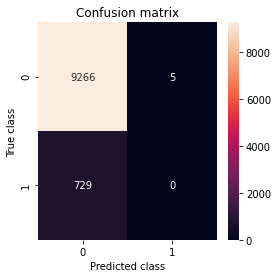

In [305]:
conf_matrix = confusion_matrix(y_val_app, y_val_pred_app)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [306]:
# generate a no skill prediction (majority class)
ns_app_probs = [0] * len(x_val_new)

# predict probabilities
lreg_app_probs = lreg_app.predict_proba(x_val_new)
# keep probabilities for the positive outcome only
lreg_app_probs = lreg_app_probs[:, 1]

# calculate scores
ns_auc_app = roc_auc_score(y_val_app, ns_app_probs)
lr_auc_app = roc_auc_score(y_val_app, lreg_app_probs)

In [307]:
print('No Skill: ROC AUC=%.3f' % (ns_auc_app))
print('Logistic: ROC AUC=%.3f' % (lr_auc_app))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.661


In [308]:
f1_app = f1_score(y_val_app, y_val_pred_app)
print("f1 score is ", np.round(f1_app,3))

f1 score is  0.0


# Data to csv

In [309]:
kdd_data.to_csv('kdd_data_cleaned.csv')